# Calcolo delle extended pareto grid
Lavoriamo sul toro piatto $T=[0,2\pi]\times[0,2\pi]/(x,0)=(x,2\pi),(0,y)=(2\pi,y)$ con funzioni a valori in $\mathbb{R}^2$ polinomiali periodiche, ovvero in seno e costeno, per esempio del tipo $(f_1(x,y),f_2(x,y))=(a\ cos(x)^2+b\ cos(y),c\ sin(x)^3+d\ sin(y)^2)$.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
import numdifftools as nd

In [3]:
#------copio dal main------
class Torus:

    #CONSTRUCTOR
    def __init__(self, precision):
        #il più grande sia il valore di precision più punti del toro considero
        self.precision = precision
        eps = 1/precision

        #Questo salva un array di coordinate x e un array di coordinate y di punti del toro
        #creo una griglia di punti: perche'?
        self.point_coords = np.mgrid[0:1:eps, 0:1:eps]

    #GETTERS
    def get_point_coords(self):
        return self.point_coords


In [4]:
#faccio un esempio con la funzione a*np.cos(x)**2+b*np.cos(y),c*np.sin(x)**3-d*np.sin(y)**2
def f_1(x):
    return 2*np.cos(x[0])**2+4*np.cos(x[1])

def f_2(x):
    return 1*np.sin(x[0])**3+3*np.sin(x[1])**2

def f(x,a,b,c,d):
    return (a*np.cos(x[0])**2+b*np.cos(x[1]),c*np.sin(x[0])**3+d*np.sin(x[1])**2)

Adesso l'idea è provare a calcolare i gradienti e dove si annullano usando delle belle funzioncine pronte, ma ho dei problemi perchè non funzionano.
successivamente usando questi risultati voglio vedere come vengono fuori le "pre-EPG" per questa specifica classe di funzioni.
Fatto ciò poi vorrei vedere:

    -come manipolare in modo sensato la nube di punti della pre-EPG in modo da fare una EPG abbastanza fedele: il fato è che usare i metodi di interpolazione potrebbe non avere senso a livello teorico per il risultato che vogliamo ottenere

    -provare a vedere se per la nostra classe di fuzioni viene meglio se facciamo noi una funzione che calcola il gradiente e una che trova gli zeri (secondo me il calcolo del gradiente fatto da noi ha senso perchè la funzione è molto particolare, quello degli zeri no)
    
    -se riusciamo a estendere la classe di funzioni ammissibili

Utilizzo per calcolare gli zeri di funzioni delle funzioni dalla libreria scipy: consultare la [documentazione](https://docs.scipy.org/doc/scipy/reference/optimize.html#id2).

Provo a lavorare su un $\epsilon$-net del toro, perchè le funzioni che volevo usare sopra mi trovano solo una radice.
    
    -costruisco la $\epsilon$-net del toro

    -spero ci siano dei punti vicini ad essere critici

In [5]:
#griglia sul toro

eps=2*np.pi/100
x=[]
for i in np.arange(0,2*np.pi+eps,eps):
    for j in np.arange(0,2*np.pi+eps,eps):
        x.append([i,j])
x=np.array(x)
l=len(x)
print(l) #ok griglia 101*101

10201


In [6]:
#provo a calcolare i gradienti con la libreria
gr1=nd.Gradient(f_1)
gr2=nd.Gradient(f_2)
#faccio una stampa per vedere come funziona
#for i in range (0,l+1,1):
#    print(x[i], gr1(x[i]))
#ho fatto un po'di conti e calcola molto bene

### Calcolo i punti critici
Infatti sappiamo che i valori critici sono gli estremi degli archi della EPG.

Per il momento non ammetto tolleranza

In [7]:
#calcolo dei punti critici di f_1 e f_2 nella griglia
cr1=[]  #lista dei punti critici di f_1
cr2=[]  #lista dei punti critici di f_2
for i in range (0,l,1):
    a=gr1(x[i])
    b=gr2(x[i])
    if a[0]==0 and a[1]==0:
        cr1.append(x[i])
        #print(x[i],"critico per f_1")
    if b[0]==0 and b[1]==0:
        cr2.append(x[i])
        #print(x[i],"critico per f_2")
cr1=np.array(cr1)
cr2=np.array(cr2)

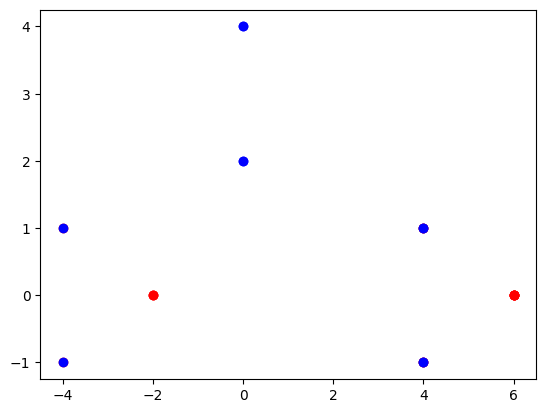

In [8]:
#faccio un plot dei valori critici per avere un'idea
plt.scatter([f_1(c) for c in cr1],[f_2(c) for c in cr1],color='red')
plt.scatter([f_1(c) for c in cr2],[f_2(c) for c in cr2],color='blue')

### Calcolo punti Pareto critici
Un punto $(x,y)\in T$ è detto Pareto Critico se $\exists \lambda\le 0$ t.c. $\nabla f_1(x,y)=\lambda\nabla f_2(x,y)$.

Questa condizione equivale a richiedere che: se $\nabla f_1(x,y)=(a,b),\ \nabla f_2(x,y)=(c,d)$, allora $\frac{a}{c}=\lambda=\frac{b}{d}$ dove queste sono ben definite.

Pertanto valuto questi rapporti, ammettendo una certa tolleranza.

(Assumiamo per ipotesi che siano finiti e disgiunti l'insieme dei punti critici di $f_1$ e l'insieme dei punti critici di $f_2$).

In [9]:
def Pareto(tol):
    #tol=0.0001   #per ora uso una sola toleranza, come se fosse il mio zero
    ppc=[]       #lista dei punti Pareto Critici
    for i in range (0,l,1):
        a=gr1(x[i])
        b=gr2(x[i])
        if b[0]==0 and b[1]==0:
            if a[0]==0 and a[1]==0:
                #print('La funzione non soddisfa le condizioni iniziali') #la nostra non soddisfa yeee
                ppc.append(x[i])
            else:
                ppc.append(x[i])
        if b[0]==0 and b[1]!=0:
            if a[0]<=tol:
                ppc.append(x[i])
        if b[1]==0 and b[0]!=0:
            if a[1]<=tol:
                ppc.append(x[i])
        if b[0]!=0 and b[1]!=0:
            if abs(a[0]/b[0]-a[1]/b[1])<=tol and (a[0]/b[0]<=tol or a[1]/a[1]<=tol):
                ppc.append(x[i])
    return ppc

Adesso faccio un po' di plot cambiando di volta in volta la tolleranza.

Osservo che: nel plot ci sono 2 punti.. come mai non mi fa bene l'immagine?

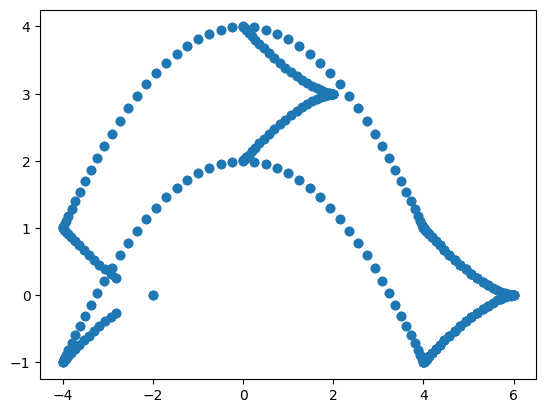

In [10]:
pareto0=Pareto(0)
plt.scatter([f_1(p) for p in pareto0],[f_2(p) for p in pareto0])

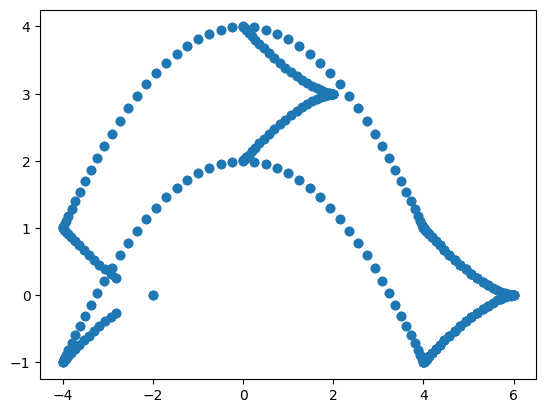

In [11]:
pareto001=Pareto(0.001)
plt.scatter([f_1(p) for p in pareto001],[f_2(p) for p in pareto001])

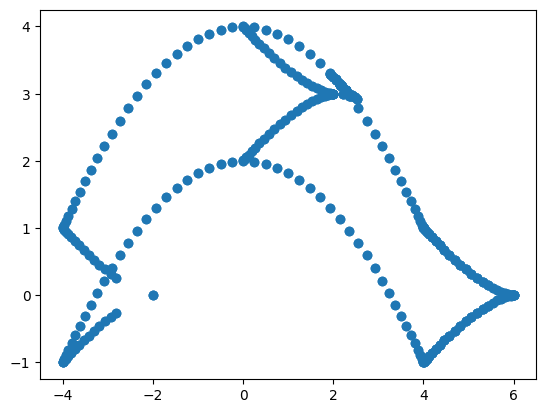

In [12]:
pareto1=Pareto(0.1)
plt.scatter([f_1(p) for p in pareto1],[f_2(p) for p in pareto1])

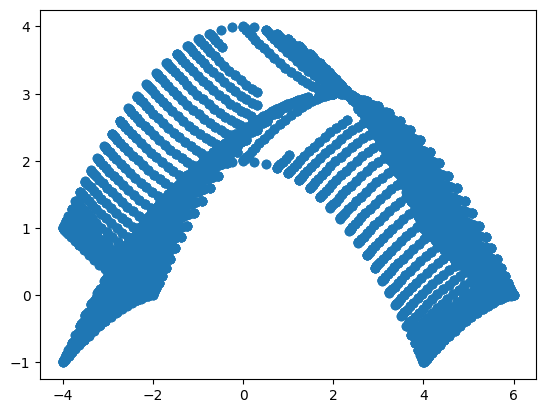

In [13]:
pareto5=Pareto(5)
plt.scatter([f_1(p) for p in pareto5],[f_2(p) for p in pareto5])